In [1]:
from datetime import datetime
import yaml
from backbone.utils.general_purpose import load_function
from backtest.utils import plot_full_equity_curve, walk_forward
import pandas as pd

root = './backbone/data'

with open('configs/live_trading.yml', 'r') as file:
    strategies = yaml.safe_load(file)

with open('configs/test_creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

date_from = datetime(2020, 1, 1)
date_to = datetime(2024, 10, 22)

not_run = [
    'backbone.eom_trader.EndOfMonthTrader',
    'backbone.vix_trader.VixTrader',    
    'backbone.b_percent_trader.BPercentTrader',
    'backbone.macd_trader.MacdTrader',
    # 'backbone.mean_reversion_trader.MeanRevTrader',
    'backbone.bbands_cross_trader.BbandsCrossTrader',
    'backbone.day_per_week_trader.DayPerWeekTrader'
]

equity_curves = {}
trades = {}
initial_value = 10_000


for bot_name, configs in strategies.items():

    instruments_info = configs['instruments_info']
    wfo_params = configs['wfo_params']
    opt_params = configs['opt_params']

    if bot_name in not_run:
        continue

    for ticker, info in instruments_info.items():

        timeframe = info['timeframe']
        
        name = f'{bot_name.split(".")[-1]}_{ticker}_{timeframe}'
        print(name)
        
        cron = info['cron']
        timeframe = info['timeframe']
    
        bot = load_function(bot_name)(ticker, timeframe, creds, opt_params, wfo_params)
        
        if bot_name == 'backbone.vix_trader.VixTrader':
            df = bot.get_full_data(date_from, date_to)
 
        else:
            df = bot.trader.get_data(date_from, date_to)
        
        
        if ticker == 'US500m' or ticker == 'USTECm' or ticker == 'US30m':
            fracc_df = df * 0.01
        else:
            fracc_df = df


        wfo_stats = walk_forward(
            bot.strategy,
            fracc_df, 
            lookback_bars=bot.wfo_params['look_back_bars'],
            validation_bars=250,
            warmup_bars=bot.wfo_params['warmup_bars'], 
            params=bot.opt_params,
            commission=7e-4, 
            margin=1/30, 
            cash=initial_value,
            verbose=True
        )
        
        equity_curves[name] = wfo_stats['_equity']
        trades[name] = wfo_stats['_trades']

MeanRevTrader_UNHm_H4
  login=82847194
  trade_mode=0
  leverage=500
  limit_orders=1024
  margin_so_mode=0
  trade_allowed=True
  trade_expert=True
  margin_mode=2
  currency_digits=2
  fifo_close=False
  balance=1374.94
  credit=0.0
  profit=-14.42
  equity=1360.52
  margin=31.87
  margin_free=1328.65
  margin_level=4268.967681204895
  margin_so_call=60.0
  margin_so_so=0.0
  margin_initial=0.0
  margin_maintenance=0.0
  assets=0.0
  liabilities=0.0
  commission_blocked=0.0
  name=Said
  server=Exness-MT5Trial11
  currency=USD
  company=Exness Technologies Ltd
train from 2021-10-27 16:00:00 to 2023-08-02 12:00:00
validate from 2023-08-02 16:00:00 to 2024-01-03 12:00:00
{'sma_period': 50, 'deviation_threshold': 0.05, 'risk': 1}
equity final: 10075.946788
train from 2022-03-03 20:00:00 to 2024-01-03 12:00:00
validate from 2024-01-03 16:00:00 to 2024-05-30 12:00:00
{'sma_period': 50, 'deviation_threshold': 0.05, 'risk': 1}
equity final: 11424.937792951927
train from 2022-08-26 16:00:00 

In [2]:
import pandas as pd

min_date = None
max_date = None

for name, curve in equity_curves.items():
    # Convertir las fechas a UTC si son tz-naive
    actual_date = curve.index[0].tz_localize('UTC') if curve.index[0].tz is None else curve.index[0].tz_convert('UTC')
    
    # Si min_date es None, inicializar con la primera fecha
    if min_date is None:
        min_date = actual_date
    # Comparar si la fecha actual es menor que min_date
    elif actual_date < min_date:
        min_date = actual_date

    # Si max_date es None, inicializar con la última fecha
    curve_last_date = curve.index[-1].tz_localize('UTC') if curve.index[-1].tz is None else curve.index[-1].tz_convert('UTC')
    
    if max_date is None:
        max_date = curve_last_date
    # Comparar si la fecha actual es mayor que max_date
    elif curve_last_date > max_date:
        max_date = curve_last_date

# Mostrar las fechas encontradas
print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")

# Calcular min_date y max_date
min_date = min_date.date()
max_date = max_date.date()

print(min_date)
print(max_date)


date_range = pd.to_datetime(pd.date_range(start=min_date, end=max_date, freq='D'))
print(date_range)

Min Date: 2023-08-02 16:00:00+00:00
Max Date: 2024-10-21 16:00:00+00:00
2023-08-02
2024-10-21
DatetimeIndex(['2023-08-02', '2023-08-03', '2023-08-04', '2023-08-05',
               '2023-08-06', '2023-08-07', '2023-08-08', '2023-08-09',
               '2023-08-10', '2023-08-11',
               ...
               '2024-10-12', '2024-10-13', '2024-10-14', '2024-10-15',
               '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-19',
               '2024-10-20', '2024-10-21'],
              dtype='datetime64[ns]', length=447, freq='D')


In [12]:

def get_wallet_equity(equity_curves, initial_equity):
    total = pd.DataFrame()
    variaciones_porcentuales = {}

    for name, curve in equity_curves.items():

        eq = equity_curves[name].copy()
        eq = eq.reset_index().rename(columns={'index':'Date'})[['Date','Equity']].sort_values(by='Date')
        eq['Date'] = pd.to_datetime(eq['Date'])
        eq['Date'] = eq['Date'].dt.floor('D')

        eq = eq.groupby('Date').agg({'Equity':'last'})

        eq = eq.reindex(date_range)
        
        eq.Equity = eq.Equity.ffill()
        eq.Equity = eq.Equity.fillna(initial_value)
        
        
        eq['variacion'] = eq['Equity'] - eq['Equity'].shift(1)
        eq['variacion_porcentual'] = eq['variacion'] / eq['Equity'].shift(1)
        
        df_variacion = pd.DataFrame(
            {
                f'variacion_{name}': eq.variacion_porcentual.fillna(0)
            }
        )
        
        total = pd.concat([total, df_variacion], axis=1)

    total = total.reset_index().rename(columns={'index':'Date'})

    # Inicializa el valor de equity
    total['Equity'] = initial_equity

    # Lista de columnas con las variaciones porcentuales
    variation_cols = [col for col in total.columns if col.startswith('variacion')]

    # Calcular la curva de equity
    for i in range(1, len(total)):
        previous_equity = total.loc[i-1, 'Equity']  # Equity del periodo anterior
        
        # Calcula el impacto monetario de cada bot por separado y suma el resultado
        impact_sum = 0
        for col in variation_cols:
            variation = total.loc[i, col]
            impact_sum += previous_equity * variation
        
        # Actualiza el equity sumando el impacto monetario total
        total.loc[i, 'Equity'] = previous_equity + impact_sum

    # Resultado final

    total = total.set_index('Date')
    return total[['Equity']]

In [13]:
if 'variaciones_porcentuales' in equity_curves.keys():
    del equity_curves['variaciones_porcentuales']

initial_equity = 10_000
total = get_wallet_equity(equity_curves=equity_curves, initial_equity=initial_equity)
equity_curves['variaciones_porcentuales'] = total


In [14]:
equity_curves.keys()

dict_keys(['MeanRevTrader_UNHm_H4', 'variaciones_porcentuales'])

In [15]:
import plotly.graph_objects as go

# Crear una figura vacía
fig = go.Figure()

# Recorrer las curvas de equity de cada bot y agregarlas al gráfico
for k, v in equity_curves.items():
    
    fig.add_trace(go.Scatter(x=v.index, y=v.Equity, mode='lines', name=k))

# Actualizar los detalles del layout del gráfico
fig.update_layout(
    title="Curvas de Equity de Múltiples Bots",
    xaxis_title="Fecha",
    yaxis_title="Equity",
    legend_title="Bots"
)

# Mostrar el gráfico
fig.show()


In [16]:
from backtest.utils import max_drawdown

max_drawdown(equity_curves['variaciones_porcentuales'].Equity)

0.10415654704629124

In [9]:
del equity_curves['variaciones_porcentuales']

# Correlaciones

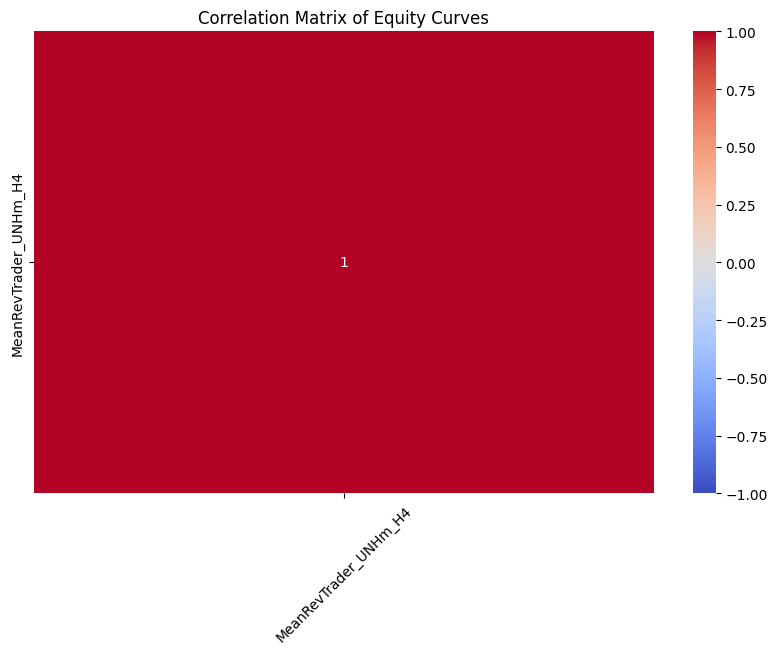

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Unir todas las curvas de equity en un solo DataFrame basado en la fecha
all_equity_df = pd.DataFrame()

for name, df in equity_curves.items():
    all_equity_df[name] = df['Equity']

# Paso 2: Calcular la matriz de correlación
correlation_matrix = all_equity_df.corr()



# Paso 3: Plotear el mapa de calor de correlación usando seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, )
plt.title('Correlation Matrix of Equity Curves')
plt.xticks(rotation=45)
plt.show()